<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[-0.39714976, -0.99190314, -0.67344518,  1.89774763,  0.58128738,
         0.45607512],
       [-1.02944257,  1.19455459,  1.40095262,  0.36937847, -0.88937075,
         2.18065936],
       [-0.33687468, -1.04486411, -0.81999565,  0.61596957, -1.1378671 ,
        -0.0409112 ],
       [-1.8963817 , -1.53208506, -1.1314012 ,  0.33365345, -0.03862103,
        -1.46945402],
       [ 0.78844254,  0.93148469, -0.16500394,  0.92888666, -0.01344445,
         0.38974785],
       [-1.2675171 ,  0.15492127,  1.15018058, -0.19067069, -0.55300559,
        -0.11129316],
       [-0.5637554 , -0.4841118 ,  0.83704216,  0.42330814, -0.73222067,
        -2.45388468],
       [-1.26532417,  0.14674322, -1.41926629, -0.32801464, -1.61404628,
         1.68356332]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.746000,-0.203158,-0.102617,0.506282,-0.549661,0.079313
std,0.812597,0.975942,1.092148,0.693235,0.702585,1.516300
min,-1.896382,-1.532085,-1.419266,-0.328015,-1.614046,-2.453885
25%,-1.265872,-1.005143,-0.897847,0.202572,-0.951495,-0.450833
50%,-0.796599,-0.168684,-0.419225,0.396343,-0.642613,0.174418
75%,-0.382081,0.349062,0.915327,0.694199,-0.032327,0.762947
max,0.788443,1.194555,1.400953,1.897748,0.581287,2.180659


In [16]:
df

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,-0.397150,-1.029443,-0.336875,-1.896382,0.788443,-1.267517,-0.563755,-1.265324
B,-0.991903,1.194555,-1.044864,-1.532085,0.931485,0.154921,-0.484112,0.146743
C,-0.673445,1.400953,-0.819996,-1.131401,-0.165004,1.150181,0.837042,-1.419266
D,1.897748,0.369378,0.615970,0.333653,0.928887,-0.190671,0.423308,-0.328015
E,0.581287,-0.889371,-1.137867,-0.038621,-0.013444,-0.553006,-0.732221,-1.614046
F,0.456075,2.180659,-0.040911,-1.469454,0.389748,-0.111293,-2.453885,1.683563


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,0.456075,0.581287,1.897748,-0.673445,-0.991903,-0.397150
2023-01-02,2.180659,-0.889371,0.369378,1.400953,1.194555,-1.029443
2023-01-03,-0.040911,-1.137867,0.615970,-0.819996,-1.044864,-0.336875
2023-01-04,-1.469454,-0.038621,0.333653,-1.131401,-1.532085,-1.896382
2023-01-05,0.389748,-0.013444,0.928887,-0.165004,0.931485,0.788443
2023-01-06,-0.111293,-0.553006,-0.190671,1.150181,0.154921,-1.267517
2023-01-07,-2.453885,-0.732221,0.423308,0.837042,-0.484112,-0.563755
2023-01-08,1.683563,-1.614046,-0.328015,-1.419266,0.146743,-1.265324


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659


In [20]:
df

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01   -0.397150
2023-01-02   -1.029443
2023-01-03   -0.336875
2023-01-04   -1.896382
2023-01-05    0.788443
2023-01-06   -1.267517
2023-01-07   -0.563755
2023-01-08   -1.265324
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454


In [24]:
df

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563


##Selection by label

In [25]:
df.loc[dates[1]]

A   -1.029443
B    1.194555
C    1.400953
D    0.369378
E   -0.889371
F    2.180659
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,-0.397150,1.897748
2023-01-02,-1.029443,0.369378
2023-01-03,-0.336875,0.615970
2023-01-04,-1.896382,0.333653
2023-01-05,0.788443,0.928887
2023-01-06,-1.267517,-0.190671
2023-01-07,-0.563755,0.423308
2023-01-08,-1.265324,-0.328015


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-1.896382,0.333653
2023-01-05,0.788443,0.928887
2023-01-06,-1.267517,-0.190671


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -1.896382
D    0.333653
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

0.3693784731587346

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

0.3693784731587346

##Selection by position

In [31]:
df.iloc[3]

A   -1.896382
B   -1.532085
C   -1.131401
D    0.333653
E   -0.038621
F   -1.469454
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-1.896382,-1.532085
2023-01-05,0.788443,0.931485


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-1.029443,1.400953
2023-01-03,-0.336875,-0.819996
2023-01-05,0.788443,-0.165004


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,-0.991903,-0.673445
2023-01-02,1.194555,1.400953
2023-01-03,-1.044864,-0.819996
2023-01-04,-1.532085,-1.131401
2023-01-05,0.931485,-0.165004
2023-01-06,0.154921,1.150181
2023-01-07,-0.484112,0.837042
2023-01-08,0.146743,-1.419266


In [36]:
# For getting values explicitly
df.iloc[1, 1]

1.1945545898538277

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

1.1945545898538277

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,NaN,NaN,NaN,1.897748,0.581287,0.456075
2023-01-02,NaN,1.194555,1.400953,0.369378,NaN,2.180659
2023-01-03,NaN,NaN,NaN,0.615970,NaN,NaN
2023-01-04,NaN,NaN,NaN,0.333653,NaN,NaN
2023-01-05,0.788443,0.931485,NaN,0.928887,NaN,0.389748
2023-01-06,NaN,0.154921,1.150181,NaN,NaN,NaN
2023-01-07,NaN,NaN,0.837042,0.423308,NaN,NaN
2023-01-08,NaN,0.146743,NaN,NaN,NaN,1.683563


In [40]:
df

,A,B,C,D,E,F
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,-0.397150,-0.991903,-0.673445,1.897748,0.581287,0.456075,one
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659,one
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911,two
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454,three
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748,four
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293,three
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885,five
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911,two
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748,four
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,0.581287,0.456075,NaN
2023-01-02,-1.029443,1.194555,1.400953,0.369378,-0.889371,2.180659,1.0
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,-1.137867,-0.040911,2.0
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,-0.038621,-1.469454,3.0
2023-01-05,0.788443,0.931485,-0.165004,0.928887,-0.013444,0.389748,4.0
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,-0.553006,-0.111293,5.0
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,-0.732221,-2.453885,6.0
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,-1.614046,1.683563,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,5,0.456075,NaN
2023-01-02,-1.029443,1.194555,1.400953,0.369378,5,2.180659,1.0
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,5,-0.040911,2.0
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,5,-1.469454,3.0
2023-01-05,0.788443,0.931485,-0.165004,0.928887,5,0.389748,4.0
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,5,-0.111293,5.0
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,5,-2.453885,6.0
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,5,1.683563,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.673445,-1.897748,-5,-0.456075,NaN
2023-01-02,-1.029443,-1.194555,-1.400953,-0.369378,-5,-2.180659,-1.0
2023-01-03,-0.336875,-1.044864,-0.819996,-0.615970,-5,-0.040911,-2.0
2023-01-04,-1.896382,-1.532085,-1.131401,-0.333653,-5,-1.469454,-3.0
2023-01-05,-0.788443,-0.931485,-0.165004,-0.928887,-5,-0.389748,-4.0
2023-01-06,-1.267517,-0.154921,-1.150181,-0.190671,-5,-0.111293,-5.0
2023-01-07,-0.563755,-0.484112,-0.837042,-0.423308,-5,-2.453885,-6.0
2023-01-08,-1.265324,-0.146743,-1.419266,-0.328015,-5,-1.683563,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,5,0.456075,1.0,1.0
2023-01-02,-1.029443,1.194555,1.400953,0.369378,5,2.180659,1.0,1.0
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,5,-0.040911,2.0,2.0
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,5,-1.469454,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,5,0.456075,1.0,1.0
2023-01-02,-1.029443,1.194555,1.400953,0.369378,5,2.180659,1.0,1.0
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,5,-0.040911,2.0,2.0
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,5,-1.469454,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,5,0.456075,1.0,1.0
2023-01-02,-1.029443,1.194555,1.400953,0.369378,5,2.180659,1.0,1.0
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,5,-0.040911,2.0,2.0
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,5,-1.469454,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,5,0.456075,NaN
2023-01-02,-1.029443,1.194555,1.400953,0.369378,5,2.180659,1.0
2023-01-03,-0.336875,-1.044864,-0.819996,0.615970,5,-0.040911,2.0
2023-01-04,-1.896382,-1.532085,-1.131401,0.333653,5,-1.469454,3.0
2023-01-05,0.788443,0.931485,-0.165004,0.928887,5,0.389748,4.0
2023-01-06,-1.267517,0.154921,1.150181,-0.190671,5,-0.111293,5.0
2023-01-07,-0.563755,-0.484112,0.837042,0.423308,5,-2.453885,6.0
2023-01-08,-1.265324,0.146743,-1.419266,-0.328015,5,1.683563,NaN


In [56]:
df.mean()

A   -0.696357
B   -0.079170
C   -0.102617
D    0.506282
E    5.000000
F    0.079313
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-1.336875,-2.044864,-1.819996,-0.384030,4.0,-1.040911,1.0
2023-01-04,-4.896382,-4.532085,-4.131401,-2.666347,2.0,-4.469454,0.0
2023-01-05,-3.211557,-3.068515,-4.165004,-3.071113,1.0,-3.610252,0.0
2023-01-06,-6.267517,-4.845079,-3.849819,-5.190671,0.0,-5.111293,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-7.265324,-5.853257,-7.419266,-6.328015,-1.0,-4.316437,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.673445,1.897748,5,0.456075,NaN
2023-01-02,-1.029443,1.194555,0.727507,2.267126,10,2.636734,1.0
2023-01-03,-1.366317,0.149690,-0.092488,2.883096,15,2.595823,3.0
2023-01-04,-3.262699,-1.382395,-1.223889,3.216749,20,1.126369,6.0
2023-01-05,-2.474256,-0.450910,-1.388893,4.145636,25,1.516117,10.0
2023-01-06,-3.741774,-0.295989,-0.238713,3.954965,30,1.404824,15.0
2023-01-07,-4.305529,-0.780100,0.598329,4.378273,35,-1.049061,21.0
2023-01-08,-5.570853,-0.633357,-0.820937,4.050259,40,0.634503,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    2.684824
B    2.726640
C    2.820219
D    2.225762
E    0.000000
F    4.634544
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    5
1    0
2    5
3    6
4    6
5    5
6    2
7    5
8    2
9    1
dtype: int64

In [62]:
s.value_counts()

5    4
6    2
2    2
0    1
1    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-0.926270,0.463022,-0.080269,0.581188
1,-0.103797,0.594009,1.440066,0.186797
2,0.487854,0.738542,0.466884,-1.262373
3,-1.382692,1.097278,2.494853,0.145038
4,0.104906,-0.336599,-1.183681,1.542269
5,-0.492277,1.699728,-0.015915,-0.026252
6,-1.321779,-0.262285,0.439808,-2.865424
7,0.544626,-0.198102,-0.694094,0.032953
8,-0.808594,-0.635697,-0.587484,2.542964
9,0.613608,0.802715,-0.943515,1.364934


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-0.926270,0.463022,-0.080269,0.581188
1,-0.103797,0.594009,1.440066,0.186797
2,0.487854,0.738542,0.466884,-1.262373
3,-1.382692,1.097278,2.494853,0.145038
4,0.104906,-0.336599,-1.183681,1.542269
5,-0.492277,1.699728,-0.015915,-0.026252
6,-1.321779,-0.262285,0.439808,-2.865424
7,0.544626,-0.198102,-0.694094,0.032953
8,-0.808594,-0.635697,-0.587484,2.542964
9,0.613608,0.802715,-0.943515,1.364934


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,0.154138,0.731451
1,bar,one,-1.187748,0.958847
2,foo,two,-1.126913,-0.330737
3,bar,three,0.394092,1.382611
4,foo,two,0.189055,1.032855
5,bar,two,0.659138,-0.660304
6,foo,one,-1.126993,-0.761530
7,foo,three,0.789702,-0.953212


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-0.134518,1.681154
foo,-1.121011,-0.281174


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -1.187748  0.958847
    three  0.394092  1.382611
    two    0.659138 -0.660304
foo one   -0.972855 -0.030080
    three  0.789702 -0.953212
    two   -0.937857  0.702118

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     0.432016  0.180387
      two    -0.558704 -0.513407
baz   one     0.494348 -1.238657
      two    -0.900264  0.048863

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    0.432016
               B    0.180387
       two     A   -0.558704
               B   -0.513407
baz    one     A    0.494348
               B   -1.238657
       two     A   -0.900264
               B    0.048863
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one     0.432016  0.180387
      two    -0.558704 -0.513407
baz   one     0.494348 -1.238657
      two    -0.900264  0.048863

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A  0.432016 -0.558704
      B  0.180387 -0.513407
baz   A  0.494348 -0.900264
      B -1.238657  0.048863

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A  0.432016  0.494348
       B  0.180387 -1.238657
two    A -0.558704 -0.900264
       B -0.513407  0.048863

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,-0.222084,1.182900
1,one,B,foo,-0.723910,1.135757
2,two,C,foo,-0.996423,1.184624
3,three,A,bar,-0.114578,0.292516
4,one,B,bar,0.838799,0.131809
5,one,C,bar,-0.435866,-0.214077
6,two,A,foo,0.214520,1.415166
7,three,B,foo,-0.034987,0.304145
8,one,C,foo,-1.774161,-1.093985
9,one,A,bar,-0.872300,0.242561


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -0.872300 -0.222084
      B  0.838799 -0.723910
      C -0.435866 -1.774161
three A -0.114578       NaN
      B       NaN -0.034987
      C -0.003351       NaN
two   A       NaN  0.214520
      B  0.226049       NaN
      C       NaN -0.996423

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    24214
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06    0.005202
2012-03-07   -0.996353
2012-03-08   -1.235530
2012-03-09   -0.120699
2012-03-10    0.941248
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00    0.005202
2012-03-07 00:00:00+00:00   -0.996353
2012-03-08 00:00:00+00:00   -1.235530
2012-03-09 00:00:00+00:00   -0.120699
2012-03-10 00:00:00+00:00    0.941248
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00    0.005202
2012-03-06 19:00:00-05:00   -0.996353
2012-03-07 19:00:00-05:00   -1.235530
2012-03-08 19:00:00-05:00   -0.120699
2012-03-09 19:00:00-05:00    0.941248
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    0.291678
2012-02-29    1.094184
2012-03-31    0.024580
2012-04-30    1.150139
2012-05-31   -1.104518
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01    0.291678
2012-02    1.094184
2012-03    0.024580
2012-04    1.150139
2012-05   -1.104518
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    0.291678
2012-02-01    1.094184
2012-03-01    0.024580
2012-04-01    1.150139
2012-05-01   -1.104518
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -0.723117
1990-06-01 09:00    0.979207
1990-09-01 09:00    0.981795
1990-12-01 09:00    1.616555
1991-03-01 09:00    0.199542
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

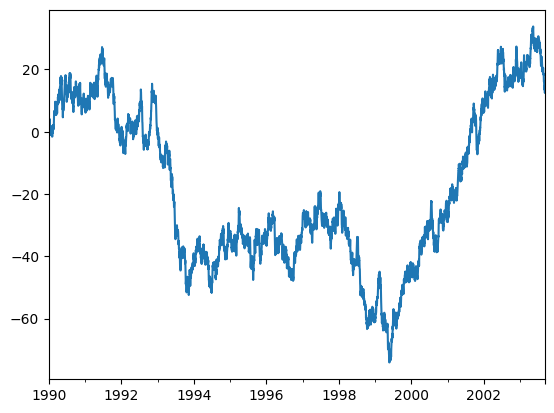

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 640x480 with 0 Axes>

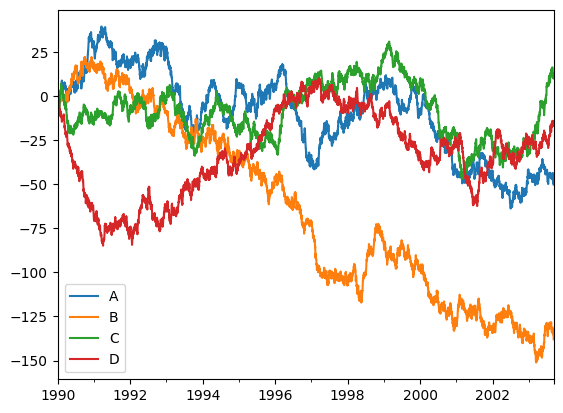

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,1.647242,0.586838,0.260580,1.479525
1,1990-01-02,1.270171,0.235494,1.884225,2.059605
2,1990-01-03,2.869052,-0.812548,-0.150820,2.040011
3,1990-01-04,2.632160,-0.692839,-0.928244,0.692143
4,1990-01-05,3.967564,-1.243590,-1.531196,1.323214
...,...,...,...,...,...
4995,2003-09-05,-49.213021,-134.607203,10.508777,-16.336249
4996,2003-09-06,-49.703849,-133.584241,10.630469,-16.502384
4997,2003-09-07,-49.400482,-136.977748,10.213146,-14.312189
4998,2003-09-08,-49.586643,-137.421232,10.056261,-14.348499


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,1.647242,0.586838,0.260580,1.479525
1990-01-02,1.270171,0.235494,1.884225,2.059605
1990-01-03,2.869052,-0.812548,-0.150820,2.040011
1990-01-04,2.632160,-0.692839,-0.928244,0.692143
1990-01-05,3.967564,-1.243590,-1.531196,1.323214
...,...,...,...,...
2003-09-05,-49.213021,-134.607203,10.508777,-16.336249
2003-09-06,-49.703849,-133.584241,10.630469,-16.502384
2003-09-07,-49.400482,-136.977748,10.213146,-14.312189
2003-09-08,-49.586643,-137.421232,10.056261,-14.348499


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,1.647242,0.586838,0.260580,1.479525
1,1990-01-02,1.270171,0.235494,1.884225,2.059605
2,1990-01-03,2.869052,-0.812548,-0.150820,2.040011
3,1990-01-04,2.632160,-0.692839,-0.928244,0.692143
4,1990-01-05,3.967564,-1.243590,-1.531196,1.323214
...,...,...,...,...,...
4995,2003-09-05,-49.213021,-134.607203,10.508777,-16.336249
4996,2003-09-06,-49.703849,-133.584241,10.630469,-16.502384
4997,2003-09-07,-49.400482,-136.977748,10.213146,-14.312189
4998,2003-09-08,-49.586643,-137.421232,10.056261,-14.348499


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -1.137917
b   -0.214363
c    0.839224
d   -0.326289
e   -0.006478
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0   -0.010788
1    1.841767
2    0.650587
3    1.100459
4    0.099954
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

c    0.839224
e   -0.006478
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [117]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [118]:
bb[bb.columns[:9]].dtypes

Unnamed: 0                         object
Unnamed: 1                         object
Unnamed: 2                         object
Unnamed: 3                         object
Unnamed: 4                         object
Unnamed: 5                         object
Unnamed: 6                         object
Percent change\nJan 2023 from -    object
Unnamed: 8                         object
dtype: object

In [119]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

##PyTorch Forecasting
**Building a simple first model**

Starting witha simple fully connected model, it'll take a timeseries of size `input_size` as input and outputs a new timeseries of size `output_size`. 

In [120]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

The above model is not yet a PyTorch Forecasting model but it is easy to get there. As this is a simple model, we will use the `BaseModel`. This base class is modified `LightningModule` with pre-defined hooks for training and validating time series models. The main requirement is for the model to have a forward method.

In [123]:
def forward(self, x:
    # x is a batch generated based on TimeSeriesDataset, here we use the
    # continuous variables for encoder
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.linear(network_input)  #
    
    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])
    
    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

SyntaxError: ignored

In [125]:
from typing import Dict

from pytorch_forecasting.models import BaseModel

class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

##Passing data to a model

Instead of having to write our own dataloader, we can leverage PyTorch Forecasting’s `TimeSeriesDataSet` to feed data to our model. In fact, PyTorch Forecasting expects us to use a `TimeSeriesDataSet`.

The data has to be in a specific format to be used by the `TimeSeriesDataSet`. It should be in a pandas DataFrame and have a categorical column to identify each series and a integer column to specify the time of the record.

Below, we create such a dataset with 30 different observations - 10 for 3 time series.

In [126]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) -0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data 

,value,group,time_idx
0,-0.186083,0,0
1,-0.190878,0,1
2,0.194305,0,2
3,0.444677,0,3
4,-0.167045,0,4
5,0.410212,0,5
6,-0.019340,0,6
7,-0.066082,0,7
8,-0.034291,0,8
9,0.302576,0,9


We can convert it to a `TimeSeriesDataSet` easily.

In [127]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

We can take a look at all the defaults and settings preset by PyTorch Forecasting. These are all available as arguments in `TimeSeriesDataSet`.

In [128]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=[],
 	center=True,
 	scale_by_group=False,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True),
  'group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

Now when we take a look at the output of the dataloader. It's `x` will be fed to the model's forward method.

In [129]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-0.0731],
         [ 0.4311],
         [ 1.2221],
         [-2.0462],
         [-0.3870]],

        [[ 0.6012],
         [-0.8634],
         [ 1.1369],
         [-0.5110],
         [-0.1070]],

        [[ 0.5766],
         [ 1.5320],
         [-0.8023],
         [ 1.4005],
         [-0.2387]],

        [[ 0.3253],
         [ 0.6012],
         [-0.8634],
         [ 1.1369],
         [-0.5110]]]), 'encoder_target': tensor([[ 0.0240,  0.1562,  0.3635, -0.4930, -0.0582],
        [ 0.2008, -0.1831,  0.3411, -0.0907,  0.0152],
        [ 0.1943,  0.4447, -0.1670,  0.4102, -0.0193],
        [ 0.1284,  0.2008, -0.1831,  0.3411, -0.0907]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[-0.2161],
         [ 1.3282]],

        [[ 1.1058],
         [-1.0095]],

        [[-0.4170],
         [-0.2957]],

        [[-0.1070],
   

Weight by samples for training:

In [131]:
from torch.utils.data import WeightedRandomSampler

# length of probabilties for sampler have to be equal to the length of the index
probabilities = np.sqrt(1 + data.loc[dataset.index, "target"])
sampler = WeightedRandomSampler(probabilities, len(probabilities))
dataset.to_dataloader(train=True, sampler=sampler, shuffle=False)

NameError: ignored

In [133]:
def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # x is a batch generated based on the TimeSeriesDataset
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.network(network_input)

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

In [135]:
model = FullyConnectedModel.from_dataset(dataset, input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x, y = next(iter(dataloader))
model(x)

NameError: ignored

In [137]:
dataset.x_to_index(x)

,time_idx,group
0,7,2
1,6,1
2,7,0
3,5,1


**Coupling datasets and models**

In [138]:
class FullyConnectedModel(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input).unsqueeze(-1)

        #rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        #We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversation to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs ={
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

Let's initialize from our dataset:

In [143]:
from lightning.pytorch.utilities.model_summary import ModelSummary

model = FullyConnectedModel.from_dataset(dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

RecursionError: ignored

##Defining additional hyperparameters

So far, we have 

In [145]:
model.hparams

NameError: ignored

In [150]:
print(BaseModel.__init__.__doc__)


        BaseModel for timeseries forecasting from which to inherit from

        Args:
            log_interval (Union[int, float], optional): Batches after which predictions are logged. If < 1.0, will log
                multiple entries per batch. Defaults to -1.
            log_val_interval (Union[int, float], optional): batches after which predictions for validation are
                logged. Defaults to None/log_interval.
            learning_rate (float, optional): Learning rate. Defaults to 1e-3.
            log_gradient_flow (bool): If to log gradient flow, this takes time and should be only done to diagnose
                training failures. Defaults to False.
            loss (Metric, optional): metric to optimize, can also be list of metrics. Defaults to SMAPE().
            logging_metrics (nn.ModuleList[MultiHorizonMetric]): list of metrics that are logged during training.
                Defaults to [].
            reduce_on_plateau_patience (int): patience after which 

##Classification

In [151]:
classification_test_data = pd.DataFrame(
    dict(
        target=np.random.choice(["A", "B", "C"], size=30), #CHANGING values to predict to a categorical
        value=np.random.rand(30), # INPUT values
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
classification_test_data

,target,value,group,time_idx
0,C,0.720071,0,0
1,A,0.457624,0,1
2,C,0.052896,0,2
3,A,0.354400,0,3
4,A,0.283399,0,4
5,C,0.632628,0,5
6,A,0.152408,0,6
7,A,0.194464,0,7
8,B,0.824776,0,8
9,B,0.698222,0,9


In [152]:
from pytorch_forecasting.data.timeseries import NaNLabelEncoder

#create the dataset from the pandas dataframe
classification_dataset = TimeSeriesDataSet(
    classification_test_data,
    group_ids=["group"],
    target="target", # SWITCHING to categorical target
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
    target_normalizer=NaNLabelEncoder(), # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(classification_dataset.to_dataloader(batch_size=4)))
y[0] # target values are encoded categories

tensor([[2, 1],
        [1, 0],
        [1, 2],
        [1, 1]])

In [153]:
from pytorch_forecasting.metrics import CrossEntropy


class FullyConnectedClassificationModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        n_classes: int,
        loss=CrossEntropy(),
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size * self.hparams.n_classes,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_cont"].size(0)
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)
        # RESHAPE output to batch_size x n_decoder_timesteps x n_classes
        prediction = prediction.unsqueeze(-1).view(batch_size, -1, self.hparams.n_classes)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a named tuple that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        assert isinstance(dataset.target_normalizer, NaNLabelEncoder), "target normalizer has to encode categories"
        new_kwargs = {
            "n_classes": len(
                dataset.target_normalizer.classes_
            ),  # ADD number of classes as encoded by the target normalizer
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
        ), "Only covariate should be in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)


model = FullyConnectedClassificationModel.from_dataset(classification_dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

RecursionError: ignored